### Data load and preprocess

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from datetime import datetime
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('../Book1.csv', sep=';')
df.dropna(subset='Intervention_code', axis=0, inplace=True)
# All the rest have preeclampsia:
# 1 received aspirin, 0 didn’t receive it. They represent our two groups.

In [3]:
df.columns

Index(['UKMcode', 'No', 'Cluster', 'Aspirin user', 'Group', 'Centre',
       'StudyPhase', 'StudyPhase.1', 'Aspirin user.1', 'Intervention_code',
       'Studyphase_code', 'Aspirin_Code', 'AdjOdds_PE_LT37_Centre',
       'GestDeliveryWks', 'Gaweek', 'intervaltreatmenttodel',
       'PregPET_Eclampsia', 'GA at PE diagnosis', 'onset PE week',
       'interval_onsettodel', 'GRAVIDA', 'PARITY', 'DOB', 'HEIGHT', 'WEIGHT',
       'ETHNICITY', 'CHRONIC_HT', 'SLE/APS', 'DMTYPE1', 'DMTYPE2',
       'INSULINUSER', 'PREVHXPE', 'FAMHXPE', 'SMOKER', 'CONCEPTION',
       'Prev_Preg', 'Preg_Interval', 'MAge_EDD', 'MAP_MOM_CENTRE',
       'UTAPI_MOM_Centre', 'PLGF_MOM_Centre', 'logMAPMoM', 'logPIMoM',
       'logPIGFMoM'],
      dtype='object')

- AdjOdds_PE_LT37_Centre (Risk for developing PE, 1:xxx)
- GestDeliveryWks (gestational age at delivery) 
- intervaltreatmenttodel (please ignore) 
- GRAVIDA (number of pregnancies she got) 
- PARITY (number of livebirth before) 
- DOB (date of  birth) 
- CHRONIC_HT (chronic hypertention) 
- SLE/APS (antiphospholipid syndrome) 
- DMTYPE1 (diabetes type 1) 
- DMTYPE2 (diabetes type 2) 
- MAP_MOM_CENTRE (Mean artery pressure MoM)
- UTAPI_MOM_Centre (Utrerine artery PI MoM) 
- PLGF_MOM_Centre (PlGF MoM)
- logMAPMoM,logPIMoM,logPIGFMoM (just log transformation of the previous MoM)

In [4]:
# Transform string to number:
for c in ['MAP_MOM_CENTRE', 'UTAPI_MOM_Centre', 'PLGF_MOM_Centre', 'logMAPMoM', 'logPIMoM', 'logPIGFMoM']:
    df[c] = [float(x.replace(',', '.')) for x in df[c]]

In [5]:
# Convert date of birth to age
def dob_to_age(dob: str) -> float:
    d, m, y = map(int, dob.split('.'))
    y += 1900 if y >= 20 else 2000  # Assume 1900s for years ≥ 50, else 2000s
    return (datetime.today() - datetime(y, m, d)).days / 365.25

df['DOB'] = [dob_to_age(x) for x in df['DOB']]

In [6]:
columns_of_interest = [
    'Gaweek',
    'Intervention_code', 
    'AdjOdds_PE_LT37_Centre', 
    'CHRONIC_HT', 
    'MAP_MOM_CENTRE', 
    'UTAPI_MOM_Centre', 
    'PLGF_MOM_Centre', 
    'SLE/APS', 
    'DMTYPE1', 
    'DMTYPE2', 
    'DOB'
]

In [7]:
df[columns_of_interest]

,Gaweek,Intervention_code,AdjOdds_PE_LT37_Centre,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,SLE/APS,DMTYPE1,DMTYPE2,DOB
8,33,1.0,72,0,1.0423,1.1713,0.5462,0,0,0.0,23.975359
12,38,1.0,61,0,1.0017,1.7310,0.6739,0,0,0.0,36.451745
13,41,1.0,37,0,1.0480,1.3636,0.4203,0,0,0.0,30.338125
14,35,1.0,82,0,1.2227,0.6335,0.5187,0,0,0.0,34.477755
15,36,1.0,7,0,1.4362,0.9253,0.5744,0,0,1.0,29.086927
...,...,...,...,...,...,...,...,...,...,...,...
851,38,0.0,5,1,1.1765,1.6995,1.0392,0,0,0.0,35.140315
852,37,0.0,50,0,1.1313,1.1157,0.9588,0,0,0.0,36.856947
853,36,0.0,26,1,1.1454,0.7024,1.4084,0,0,0.0,38.885695
854,37,0.0,56,0,1.0623,1.3515,1.0526,0,0,0.0,43.329227


### Check for batch effect

In [8]:
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(df[columns_of_interest])

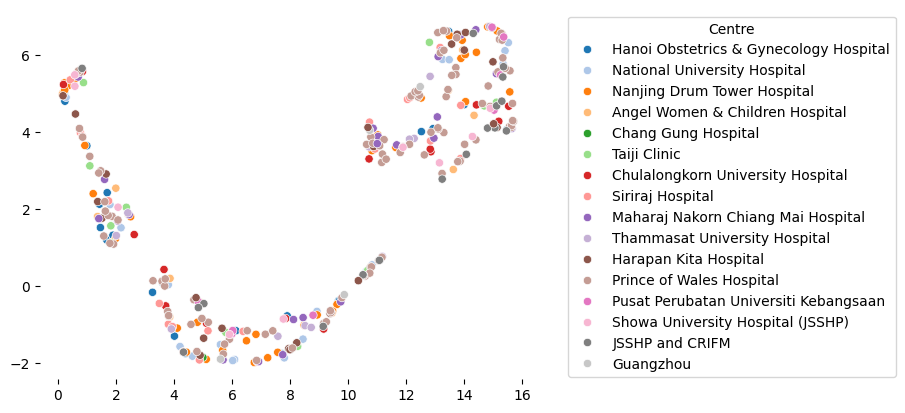

In [9]:
batches = list(df["Centre"].unique())
batches_dict = {k:v for v, k in enumerate(batches)}

sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=df['Centre'], palette="tab20")
sns.despine(left=True, bottom=True)
plt.legend(title="Centre", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Features correlation and distribution

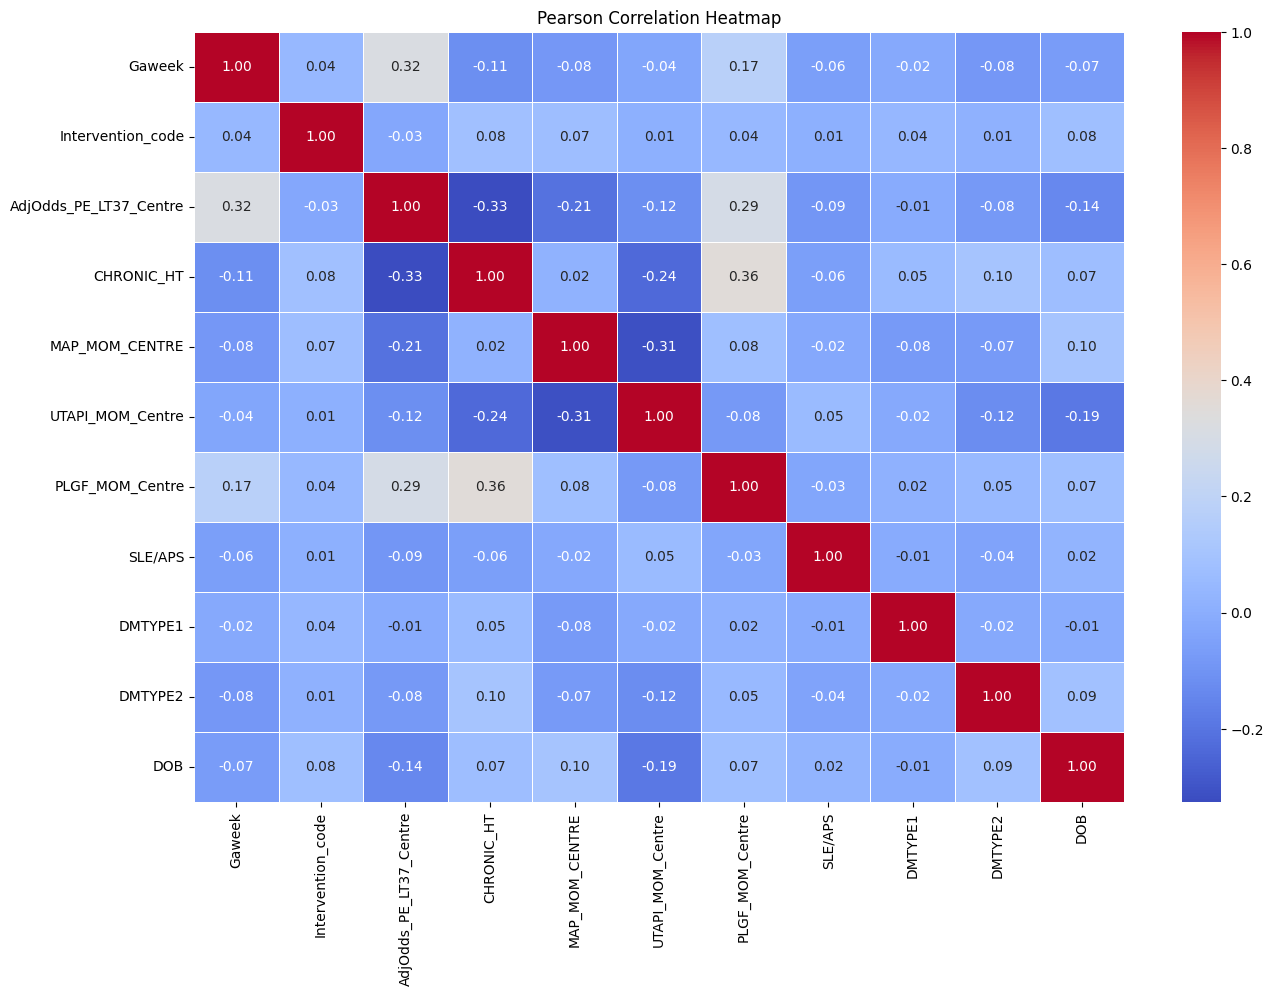

In [10]:
correlation_matrix = df[columns_of_interest].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

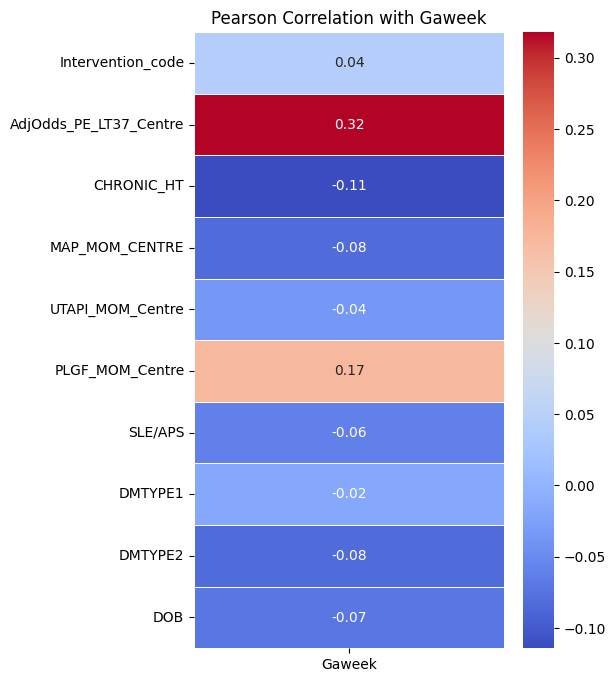

In [11]:
correlation = df[columns_of_interest].corr()[['Gaweek']].drop('Gaweek')

plt.figure(figsize=(5, len(correlation) * 0.5 + 3))  # Adjust height dynamically
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Pearson Correlation with Gaweek')
plt.show()

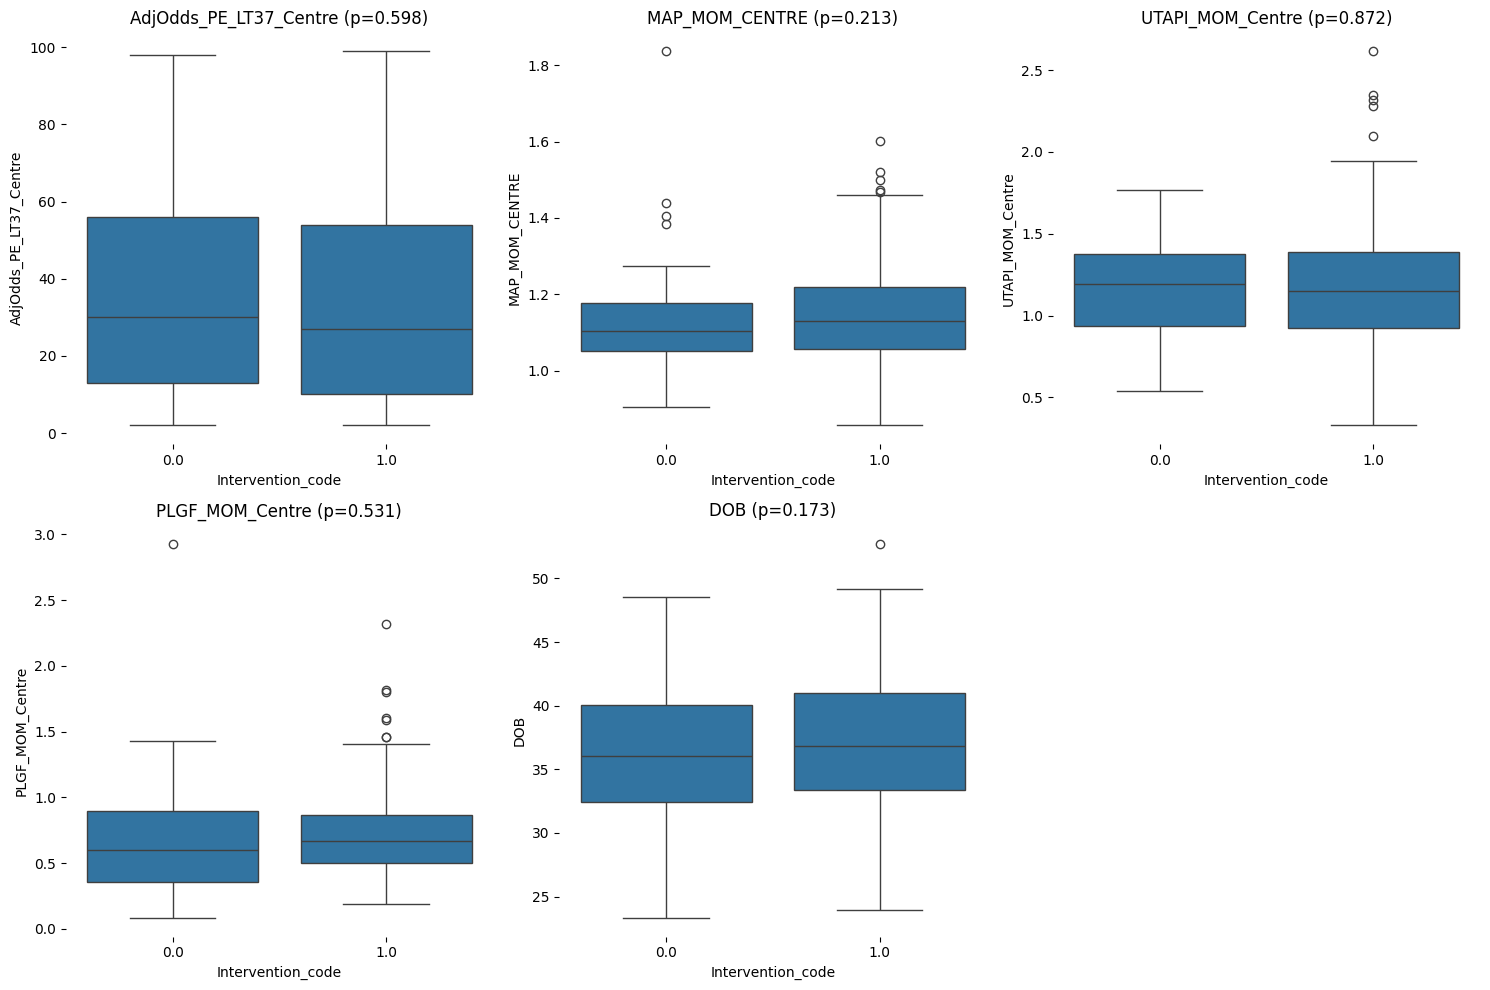

In [12]:
# Boxplots and T-test only for numeric features (skip binary)
features = [col for col in columns_of_interest[2:] if df[col].nunique() > 2]

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='Intervention_code', y=feature, data=df, ax=axes[i])
    asa_group = df[df['Intervention_code'] == 1][feature]
    non_asa_group = df[df['Intervention_code'] == 0][feature]
    t_stat, p_value = ttest_ind(asa_group, non_asa_group, equal_var=False)
    axes[i].set_title(f'{feature} (p={p_value:.3f})')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)


# Hide unused subplots if features are less than available grid slots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Model training

In [13]:
from pyopls import OPLS
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import os
os.environ["PYTHONWARNINGS"] = "ignore"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Intervention_code: 1 received aspirin, 0 didn’t receive it. They represent our two groups.

In [14]:
df['Intervention_code'].value_counts()

Intervention_code
1.0    280
0.0     64
Name: count, dtype: int64

In [15]:
# Train on aspirin data
# Train on larger group, compare predictions on other

X = df[df['Intervention_code'] == 1][columns_of_interest]
non_asa = df[df['Intervention_code'] == 0][columns_of_interest]
non_asa.drop(['Intervention_code'], axis=1, inplace=True)
y = X['Gaweek']
X.drop(['Gaweek', 'Intervention_code'], axis=1, inplace=True)

In [16]:
def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

mean_error_scorer = make_scorer(mean_error, greater_is_better=False)
mean_absolute_error_scorer = make_scorer(mean_absolute_error, greater_is_better=True)
mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
r2_scorer = make_scorer(r2_score)

# nested cross validation
def get_best_params_reg(pipeline, params, X, y):
    
    grid = GridSearchCV(pipeline, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=7), 
                        scoring='neg_mean_squared_error', n_jobs=-1)

    cv = KFold(n_splits=5, shuffle=True, random_state=7)
    scoring = {
        'mean_error': mean_error_scorer,
        'mean_absolute_error': mean_absolute_error_scorer,
        'mean_squared_error': mean_squared_error_scorer,
        'r2': r2_scorer
    }
    
    scores = cross_validate(grid, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

def print_scores(scores):
    print(f'Mean error: {np.mean(scores["test_mean_error"])}')
    print(f'Mean absolute error: {np.mean(scores["test_mean_absolute_error"])}')
    print(f'Mean squared error: {np.mean(scores["test_mean_squared_error"])}')
    print(f'R2: {np.mean(scores["test_r2"])}')

In [17]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 10],
    'regressor__learning_rate': [0.001, 0.01, 0.1],
}


scores, best_params = get_best_params_reg(pipe, params, X, y)

print(best_params)
print_scores(scores)

{'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Mean error: 0.012752103805541986
Mean absolute error: 2.0178897517068046
Mean squared error: 7.761668064778769
R2: 0.0016868321993608547


In [18]:
pipe_xgb = Pipeline([
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 10],
    'regressor__learning_rate': [0.001, 0.01, 0.1],
}

scores_xgb, best_params_xgb = get_best_params_reg(pipe_xgb, params, X, y)

print(best_params_xgb)
print_scores(scores_xgb)

{'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Mean error: 0.012752103805541986
Mean absolute error: 2.0178897517068046
Mean squared error: 7.761668064778769
R2: 0.0016868321993608547


In [19]:
pipe_opls = Pipeline([
    ('scaler', StandardScaler()), 
    ('opls', OPLS()),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

params = {
    'opls__n_components' : [1, 2, 3, 4],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 10],
    'regressor__learning_rate': [0.001, 0.01, 0.1]
}

scores_opls, best_params_opls = get_best_params_reg(pipe_opls, params, X, y)

print(best_params_opls)
print_scores(scores_opls)

{'opls__n_components': 2, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Mean error: 0.007714618955339703
Mean absolute error: 2.015243482589722
Mean squared error: 7.814699761145948
R2: -0.012380996249657406


In [20]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', RandomForestRegressor(random_state=47))
])

params = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [3, 5, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }

scores_rf, best_params_rf = get_best_params_reg(pipe_rf, params, X, y)

print(best_params_rf)
print_scores(scores_rf)

{'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Mean error: 0.002607094093871587
Mean absolute error: 1.8979838521086783
Mean squared error: 6.900666311167084
R2: 0.12451833973897435


### Model comparison on non-aspirin data

In [21]:
def calculate_shift(y_true, y_pred):

    print(f'Mean error: {mean_error(y_true, y_pred)}')
    print(f'Mean absolute error: {mean_absolute_error(y_true, y_pred)}')
    print(f'Mean squared error: {mean_squared_error(y_true, y_pred)}')
    
    errors = y_true - y_pred
    
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.title("Gestational age on non aspirin group")
    plt.show()


    # expectation: red line shifted from 0
    mean_error_value = np.mean(errors)
    median_error = np.median(errors)
    plt.figure(figsize=(6, 4))
    sns.histplot(errors, bins=30, kde=True)
    plt.axvline(mean_error_value, color='red', linestyle='--', label=f"Mean error: {mean_error_value:.2f}")
    plt.axvline(median_error, color='black', linestyle='--', label=f"Median error: {median_error:.2f}")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.title("Residual distribution")
    plt.legend()
    plt.show()


In [28]:
pipe_rf.set_params(**best_params_rf)
pipe_rf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=3, random_state=47))])

Mean error: -0.3165452120248652
Mean absolute error: 2.4498355349246204
Mean squared error: 11.285061905585568


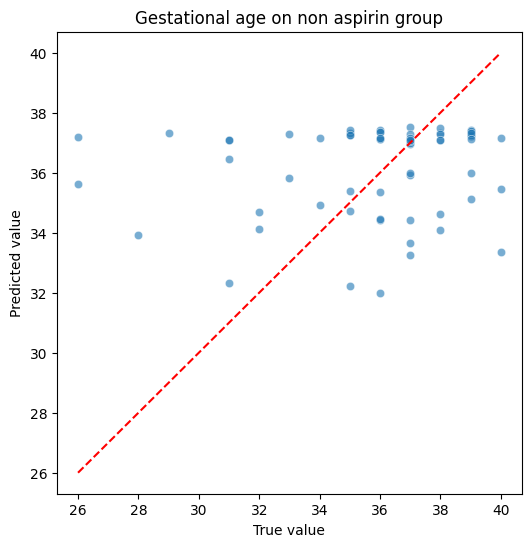

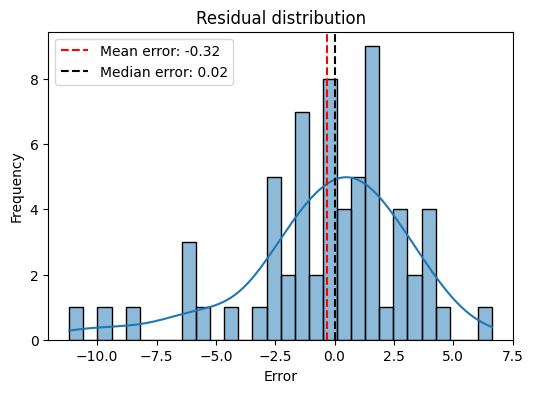

In [29]:
y_pred_non_asa = pipe_rf.predict(X_non_asa)
calculate_shift(y_non_asa, y_pred_non_asa)

#### Test only on gestation week < 36

In [30]:
non_asa_test = non_asa[non_asa['Gaweek'] < 36]
print(f'Number of samples in < 36 weeks: {non_asa_test.shape[0]}')

Number of samples in < 36 weeks: 21


Mean error: -3.6540696259759176
Mean absolute error: 3.942493126139402
Mean squared error: 24.129336688503386


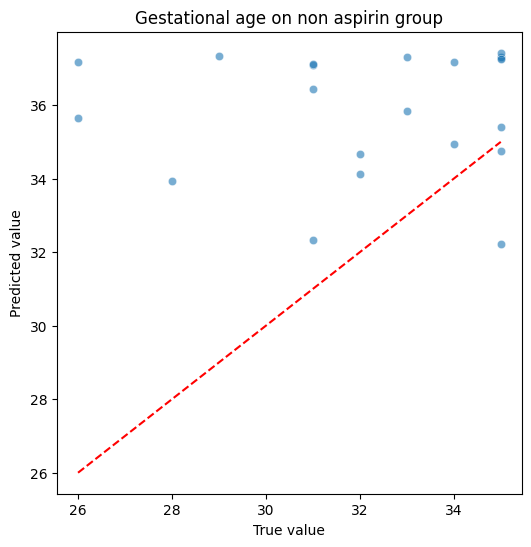

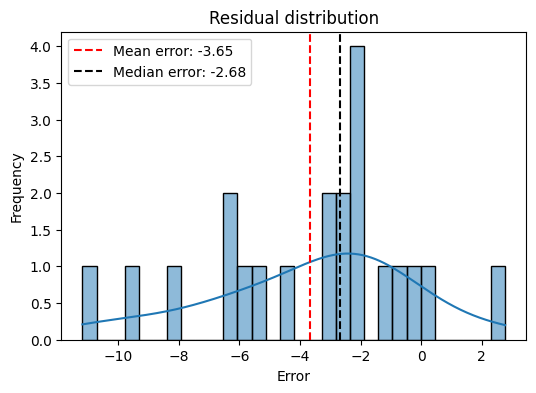

In [31]:
y_pred_non_asa_36 = pipe_rf.predict(X_non_asa_36)
calculate_shift(y_non_asa_36, y_pred_non_asa_36)

In [32]:
# Predictions on train data
y_train_pred = pipe_rf.predict(X)
train_errors = np.abs(y - y_train_pred)

var_train = np.var(train_errors)
std_train = np.std(train_errors)

print(f"Variance: {var_train:.4f}")
print(f"Standard deviation: {std_train:.4f}")


Variance: 2.2210
Standard deviation: 1.4903
